In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/deep_learning_project/

/content/drive/.shortcut-targets-by-id/15gKjVs5Brz2wVAZdIJoqScr7ejFRXBo9/deep_learning_project


In [ ]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
# from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras import optimizers

# train all data

In [ ]:
X_train=np.load('/content/drive/MyDrive/deep_learning_project/X_train.npy')
X_test=np.load('/content/drive/MyDrive/deep_learning_project/X_test.npy')
y_train=np.load('/content/drive/MyDrive/deep_learning_project/y_train.npy')
y_test=np.load('/content/drive/MyDrive/deep_learning_project/y_test.npy')

# load pretrained model

In [ ]:
from keras.layers import Input
from keras.applications.vgg16 import VGG16, preprocess_input

vgg16_input = Input(shape = (224, 224, 3), name = 'Image_input')
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)
model_vgg16_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from keras.models import Model


output_vgg16_conv = model_vgg16_conv(vgg16_input)

#Add the fully-connected layers 
x=GlobalAveragePooling2D()(output_vgg16_conv)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.1)(x) # **reduce dropout 
x=Dense(1024,activation='relu')(x) #dense layer 2
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x) #dense layer 3
x = Dense(10, activation='softmax', name='predictions')(x)

vgg16_pretrained = Model(vgg16_input, x)
vgg16_pretrained.summary()

# Compile CNN model
sgd = optimizers.SGD(lr = 0.001)
vgg16_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096  

In [ ]:
import time

#Record time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

# train the model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )

# Fits the model on batches with real-time data augmentation:
vgg16_model = vgg16_pretrained.fit_generator(datagen.flow(X_train, y_train, batch_size = 64),steps_per_epoch = len(X_train) / 64, callbacks=[time_callback],
                                                            epochs = 80, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/80
125/125 [==============================] - 96s 700ms/step - loss: 2.8968 - accuracy: 0.1201 - val_loss: 2.5240 - val_accuracy: 0.1389
Epoch 2/80
125/125 [==============================] - 83s 661ms/step - loss: 2.6285 - accuracy: 0.1357 - val_loss: 2.3904 - val_accuracy: 0.1756
Epoch 3/80
125/125 [==============================] - 83s 663ms/step - loss: 2.4005 - accuracy: 0.1920 - val_loss: 1.6365 - val_accuracy: 0.4084
Epoch 4/80
125/125 [==============================] - 84s 668ms/step - loss: 2.0319 - accuracy: 0.3016 - val_loss: 1.4865 - val_accuracy: 0.4322
Epoch 5/80
125/125 [==============================] - 83s 664ms/step - loss: 1.6950 - accuracy: 0.4113 - val_loss: 0.9685 - val_accuracy: 0.6536
Epoch 6/80
125/125 [==============================] - 84s 672ms/step - loss: 1.3783 - accuracy: 0.5227 - val_loss: 0.6610 - val_accuracy: 0.8165
Epoch 7/80
125/125 [==============================] - 84s 668ms/step - loss: 1.2131 - accuracy: 0.5854 - val_loss: 0.7019 - val_ac

In [ ]:
vgg16_model = pd.DataFrame(vgg16_model.history)
vgg16_model['time'] = time_callback.times
vgg16_model.to_csv('transfer_vgg_with_extra_layers.csv')

# LR schedule

In [ ]:
from keras.models import Model


output_vgg16_conv = model_vgg16_conv(vgg16_input)

#Add the fully-connected layers 
x=GlobalAveragePooling2D()(output_vgg16_conv)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.1)(x) # **reduce dropout 
x=Dense(1024,activation='relu')(x) #dense layer 2
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x) #dense layer 3
x = Dense(10, activation='softmax', name='predictions')(x)

vgg16_pretrained = Model(vgg16_input, x)
vgg16_pretrained.summary()

# Compile CNN model
sgd = optimizers.SGD(lr = 0.001)
vgg16_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096  

In [ ]:
import time

#Record time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

import tensorflow as tf
#Learning rate schedule
def scheduler(epoch, lr):
  if epoch < 51:
    return lr
  else:
    return lr * 0.1

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

#earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )


# Fits the model on batches with real-time data augmentation:
vgg16_model = vgg16_pretrained.fit_generator(datagen.flow(X_train, y_train, batch_size = 64),steps_per_epoch = len(X_train) / 64, callbacks=[lr_schedule,
                                                                                                                                             time_callback],
                                                            epochs = 100, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/100
269/269 [==============================] - 235s 784ms/step - loss: 2.9026 - accuracy: 0.1052 - val_loss: 2.3988 - val_accuracy: 0.1491
Epoch 2/100
269/269 [==============================] - 203s 750ms/step - loss: 2.5931 - accuracy: 0.1254 - val_loss: 2.1293 - val_accuracy: 0.1970
Epoch 3/100
269/269 [==============================] - 202s 749ms/step - loss: 2.2396 - accuracy: 0.2226 - val_loss: 1.4244 - val_accuracy: 0.4789
Epoch 4/100
269/269 [==============================] - 202s 748ms/step - loss: 1.5459 - accuracy: 0.4731 - val_loss: 0.6910 - val_accuracy: 0.8130
Epoch 5/100
269/269 [==============================] - 201s 745ms/step - loss: 1.1108 - accuracy: 0.6262 - val_loss: 0.6060 - val_accuracy: 0.8059
Epoch 6/100
269/269 [==============================] - 200s 742ms/step - loss: 0.9197 - accuracy: 0.6942 - val_loss: 0.6840 - val_accuracy: 0.7672
Epoch 7/100
269/269 [==============================] - 200s 740ms/step - loss: 0.8096 - accuracy: 0.7319 - val_loss: 0

In [ ]:
vgg16_model = pd.DataFrame(vgg16_model.history)
vgg16_model['time'] = time_callback.times
vgg16_model.to_csv('transfer_vgg_with_extra_layers_lrschedule.csv')

In [ ]:
his=pd.read_csv('/content/drive/MyDrive/deep_learning_project/transfer_vgg_with_extra_layers.csv')

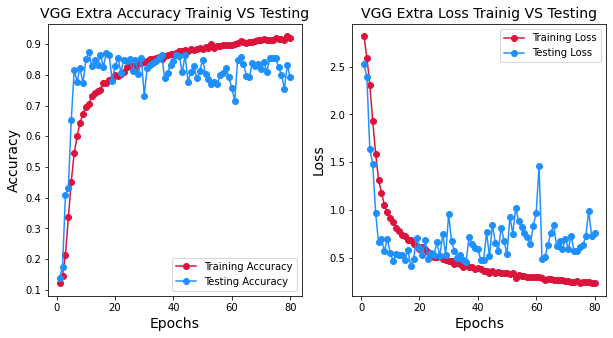

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(his['accuracy']) + 1), his['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(his['val_accuracy']) + 1), his['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('VGG Extra Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(his['loss']) + 1), his['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(his['val_loss']) + 1), his['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('VGG Extra Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')